In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import vit_b_32, ViT_B_32_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [2]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [3]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, stratify=img_labels['label'])

display(train_df.head())

training_data = GlobalStreetscapesSample(
    train_df
)

test_data = GlobalStreetscapesSample(
    test_df
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)

samples rows: 190693
paths rows: 200660
img_labels rows: 190693


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,lat,lon,path
76123,516d8b0c-cddf-4ac3-b24e-18b180be53e8,Mapillary,773465710573125,Washington,United States,USA,9923602159880896512,86,38.898308,-77.031042,../data/imgs/e4ee5166-9827-44fc-a9e7-a84bbb8da...
13202,1d1564fb-90d8-4ba3-8ac9-b0a2a18a8434,Mapillary,177119541450716,Washington,United States,USA,9923602121226190848,61,38.903307,-77.020598,../data/imgs/d9bbaaad-735f-42fc-8c29-a35fcff9e...
44857,5dba08c8-3d60-400a-912a-bb5924878dbd,Mapillary,2075703845917035,Washington,United States,USA,9923602119078707200,18,38.902569,-77.018442,../data/imgs/d5f28fda-86b1-4fc0-8eff-d4244506f...
31793,bd2522c7-8085-4b00-a2bf-c9c700c8bfb4,Mapillary,2891708994479141,Washington,United States,USA,9923602123373674496,74,38.900877,-77.021730,../data/imgs/c99606e0-9499-404c-9ba7-b228b5db1...
57703,729382a6-c8ed-4459-aced-e3e8f93813c3,Mapillary,723600302274816,Washington,United States,USA,9923602119078707200,18,38.902510,-77.016174,../data/imgs/89ad058b-a4a4-41f0-b0c7-7d8752278...


Washington


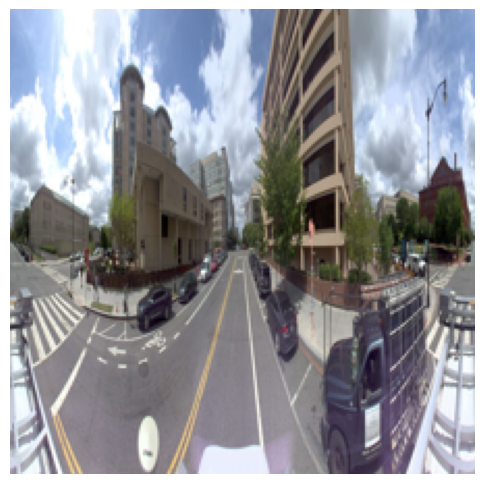

In [4]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html
weights = ViT_B_32_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_b_32(weights=weights)

in_features = model.heads.head.in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.heads.head}")
model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)
model.num_classes = num_classes
print(f"Previous head: {model.heads.head}")
print(f"Number of classes: {model.num_classes}")

model = model.to(device=device)
model = torch.compile(model)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


100%|██████████| 337M/337M [00:00<00:00, 419MB/s] 


Previous head: Linear(in_features=768, out_features=1000, bias=True)
Previous head: Linear(in_features=768, out_features=144, bias=True)
Number of classes: 144
Using device: cuda


In [7]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Changed to OneCycleLR with 10% warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)
train_loss_list = []
avg_train_loss_list = []
train_loss = 0
for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step() # Moved inside the batch loop for OneCycleLR
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_loss += avg_train_loss
    print(f"Loss: {avg_train_loss:.3f} ({train_loss / (epoch+1):.3f})")
    train_loss_list.append(avg_train_loss)
    avg_train_loss_list.append(train_loss / (epoch+1))
    # Print current LR to verify schedule
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    torch.save(model.state_dict(), f'vit_b_16_base_epoch{epoch}.pth')

EPOCH: 1


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 4.180 (4.180)
LR: 0.000052
EPOCH: 2


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 2.566 (3.373)
LR: 0.000100
EPOCH: 3


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.930 (2.892)
LR: 0.000099
EPOCH: 4


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.586 (2.565)
LR: 0.000097
EPOCH: 5


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.360 (2.324)
LR: 0.000093
EPOCH: 6


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.196 (2.136)
LR: 0.000088
EPOCH: 7


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.068 (1.984)
LR: 0.000082
EPOCH: 8


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.966 (1.856)
LR: 0.000075
EPOCH: 9


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.903 (1.750)
LR: 0.000067
EPOCH: 10


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.870 (1.662)
LR: 0.000059
EPOCH: 11


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.849 (1.588)
LR: 0.000050
EPOCH: 12


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.835 (1.526)
LR: 0.000041
EPOCH: 13


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.828 (1.472)
LR: 0.000033
EPOCH: 14


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.824 (1.426)
LR: 0.000025
EPOCH: 15


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.822 (1.385)
LR: 0.000018
EPOCH: 16


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.350)
LR: 0.000012
EPOCH: 17


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.319)
LR: 0.000007
EPOCH: 18


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.820 (1.291)
LR: 0.000003
EPOCH: 19


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.820 (1.267)
LR: 0.000001
EPOCH: 20


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.820 (1.244)
LR: 0.000000


In [8]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/149 [00:00<?, ?it/s]

Test Loss: 1.616
Test Accuracy: 79.43%


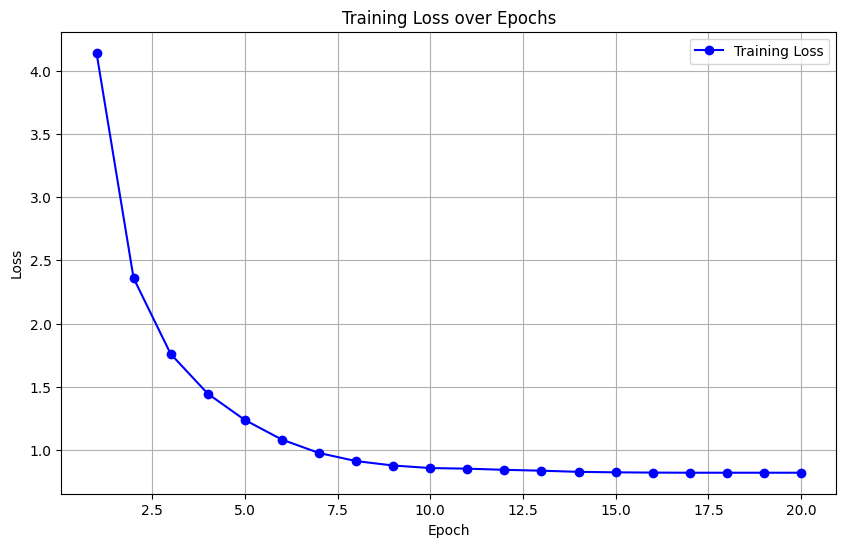

In [1]:
import matplotlib.pyplot as plt

# Raw output logs
log_data = """
EPOCH: 1
Loss: 4.141 (4.141)
EPOCH: 2
Loss: 2.359 (3.250)
EPOCH: 3
Loss: 1.760 (2.753)
EPOCH: 4
Loss: 1.446 (2.426)
EPOCH: 5
Loss: 1.238 (2.189)
EPOCH: 6
Loss: 1.083 (2.004)
EPOCH: 7
Loss: 0.977 (1.858)
EPOCH: 8
Loss: 0.913 (1.740)
EPOCH: 9
Loss: 0.878 (1.644)
EPOCH: 10
Loss: 0.858 (1.565)
EPOCH: 11
Loss: 0.853 (1.500)
EPOCH: 12
Loss: 0.844 (1.446)
EPOCH: 13
Loss: 0.837 (1.399)
EPOCH: 14
Loss: 0.828 (1.358)
EPOCH: 15
Loss: 0.824 (1.322)
EPOCH: 16
Loss: 0.822 (1.291)
EPOCH: 17
Loss: 0.821 (1.264)
EPOCH: 18
Loss: 0.821 (1.239)
EPOCH: 19
Loss: 0.821 (1.217)
EPOCH: 20
Loss: 0.821 (1.197)
"""

epochs = []
losses = []

# Parse the logs
for line in log_data.strip().split('\n'):
    if line.startswith("EPOCH:"):
        epochs.append(int(line.split(":")[1].strip()))
    elif line.startswith("Loss:"):
        # Extract the first number (current epoch loss)
        loss_val = float(line.split()[1])
        losses.append(loss_val)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()